In [119]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

### Exploration

In [99]:
df = pd.read_csv('../../data/feature_store/data_with_new_features.csv')

In [100]:
df.sample(5)

,age,experience,income,zip_code,family,cc_avg,education,mortgage,personal_loan,securities_account,cd_account,online,credit_card,age_bracket,age_bracket_name,income_per_family_member,cc_to_income_ratio,debt_to_income_ratio,financial_maturity_index
2841,56,32,190,90032,3,2.2,1,0,1,0,1,1,0,3,Generation X,47.500000,0.011579,0.011579,86.363636
3792,54,30,54,94550,1,1.6,3,185,0,0,0,1,0,3,Generation X,27.000000,0.029630,3.455556,33.750000
1672,61,37,31,92374,3,0.4,2,0,0,0,0,0,1,4,Baby boomers,7.750000,0.012903,0.012903,77.500000
1475,30,4,35,92130,2,0.3,2,0,0,1,0,0,1,2,Millennials,11.666667,0.008571,0.008571,116.666667
1507,59,34,30,92084,1,1.3,1,0,0,0,0,1,1,4,Baby boomers,15.000000,0.043333,0.043333,23.076923


In [102]:
numerical = ['age', 'experience', 'income', 'family', 'mortgage']

categorical = ['age_bracket_name', 'personal_loan', 'education', 
               'securities_account', 'cd_account', 'online']

df_numerical = df[numerical].copy()
df_categorical = df[categorical].copy()

In [103]:
df_numerical

,age,experience,income,family,mortgage
0,25,1,49,4,0
1,45,19,34,3,0
2,39,15,11,1,0
3,35,9,100,1,0
4,35,8,45,4,0
...,...,...,...,...,...
4889,29,3,40,1,0
4890,30,4,15,4,85
4891,63,39,24,2,0
4892,65,40,49,3,0


In [104]:
df_categorical

,age_bracket_name,personal_loan,education,securities_account,cd_account,online
0,Generation Z,0,1,1,0,0
1,Generation X,0,1,1,0,0
2,Millennials,0,1,0,0,0
3,Millennials,0,2,0,0,0
4,Millennials,0,2,0,0,0
...,...,...,...,...,...,...
4889,Millennials,0,3,0,0,1
4890,Millennials,0,1,0,0,1
4891,Baby boomers,0,3,0,0,0
4892,Baby boomers,0,2,0,0,1


In [105]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894 entries, 0 to 4893
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   age         4894 non-null   int64
 1   experience  4894 non-null   int64
 2   income      4894 non-null   int64
 3   family      4894 non-null   int64
 4   mortgage    4894 non-null   int64
dtypes: int64(5)
memory usage: 191.3 KB


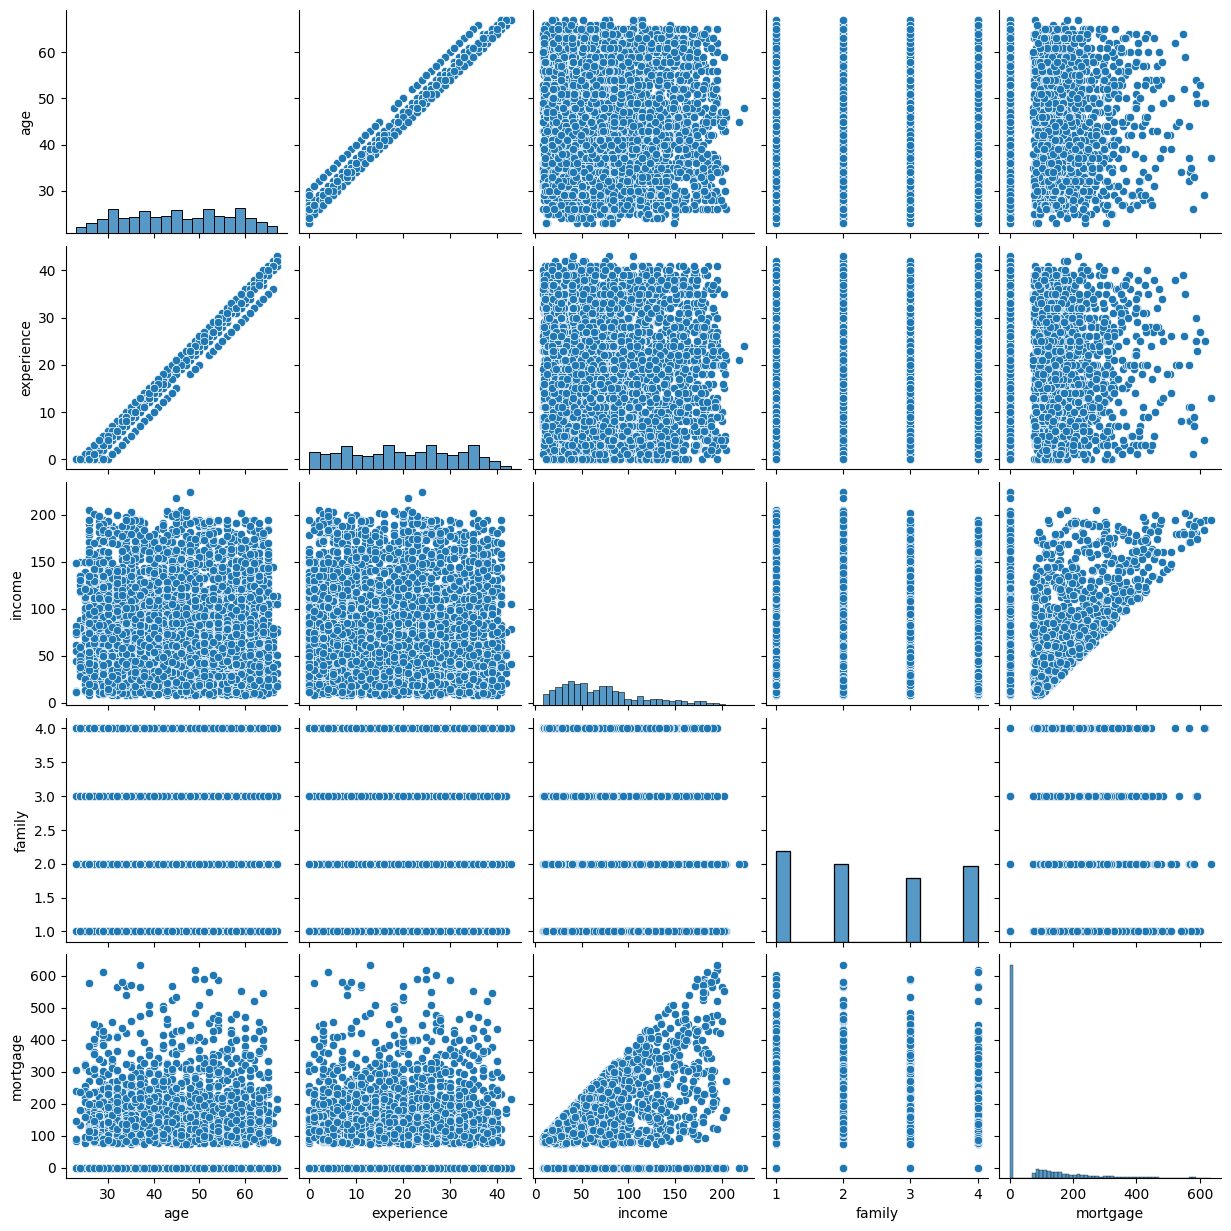

In [106]:
sns.pairplot(data=df_numerical)

In [107]:
df[['age']].describe()

,age
count,4894.000000
mean,45.333265
std,11.474275
min,23.000000
25%,35.000000
50%,45.000000
75%,55.000000
max,67.000000


In [108]:
a = df_numerical['age'].max() - df_numerical['age'].min()
print('Range: {}'.format(a))

Range: 44


### Analysis and preprocess for numerical features

In [109]:
df.isnull().sum()

age                         0
experience                  0
income                      0
zip_code                    0
family                      0
cc_avg                      0
education                   0
mortgage                    0
personal_loan               0
securities_account          0
cd_account                  0
online                      0
credit_card                 0
age_bracket                 0
age_bracket_name            0
income_per_family_member    0
cc_to_income_ratio          0
debt_to_income_ratio        0
financial_maturity_index    0
dtype: int64

Outliers

In [113]:
z_scores = stats.zscore(df_numerical)
outliers = (abs(z_scores) > 3).sum()
outliers

/tmp/ipykernel_16556/3707035125.py:1: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  z_scores = stats.zscore(df_numerical)


age             0
experience      0
income          2
family          0
mortgage      103
dtype: int64

Multicolinearidade

In [112]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(df_numerical.values, i) for i in range(len(df_numerical.columns))]

vif_data

,feature,VIF
0,age,42.995810
1,experience,21.503630
2,income,3.733379
3,family,5.500704
4,mortgage,1.368817


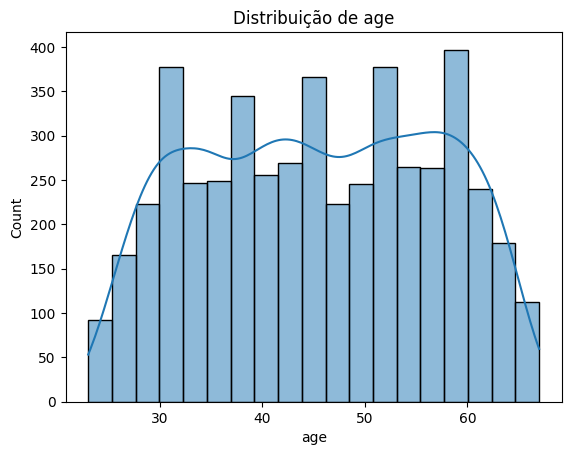

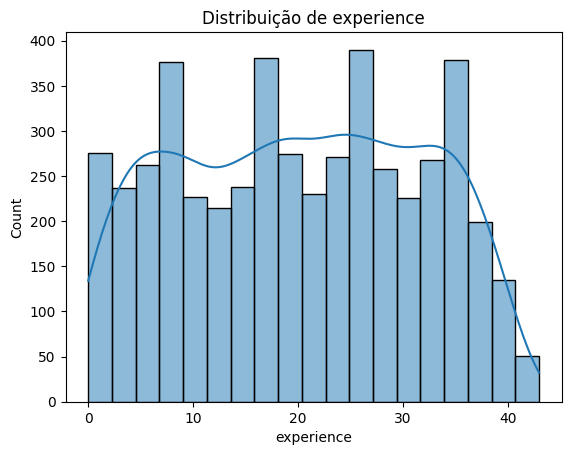

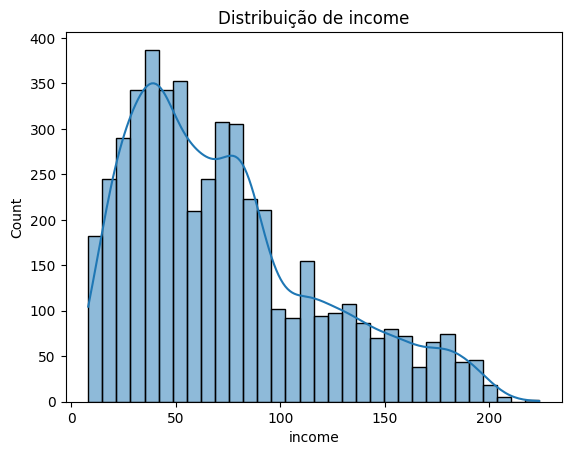

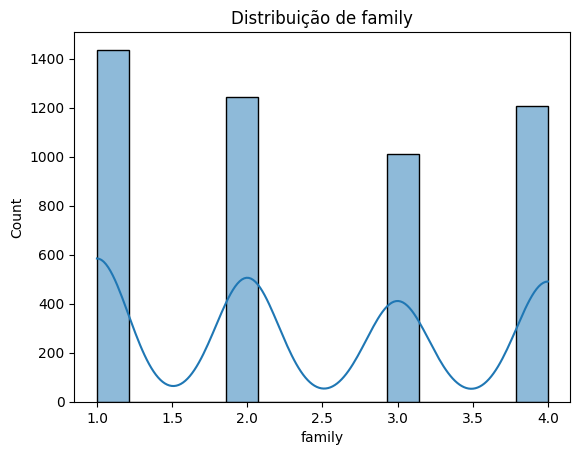

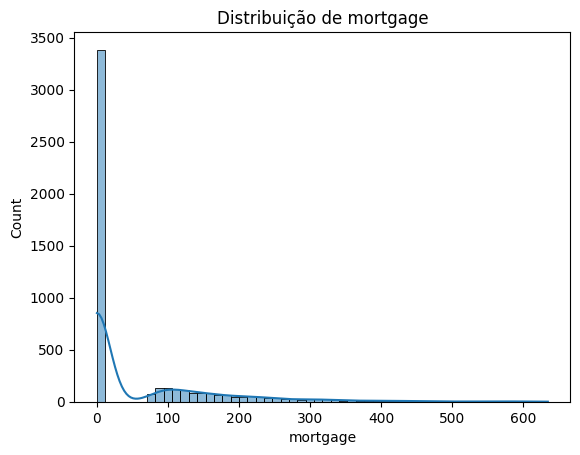

In [114]:
for col in df_numerical.columns:
    sns.histplot(df_numerical[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.show()

##### Algumas observações

**Sobre os outliers:**

A coluna 'mortgage' se destacou na analise com z score. Vamos tratar usando transformação logaritmica, pois ajuda a estabilizar a variância e consegue deixar a distribuição um pouco mais parecida com um 'sino' quando visualizamos um histograma.

$x′=log(x+1)$

Vemos também que nessa coluna há vários individuos que não tem hipotecas (valores = 0.00).

**Sobre a multicolinearidade:**
*Flags*
> 0: Não preocupa

> 1: Moderada com ponto de **atenção!**

> 2: Alta

```
age: VIF = 42.99 (2)
experience: VIF = 21.50 (2)
income: VIF = 3.73 (0)
family: VIF = 5.50 (1)
mortgage: VIF = 1.37 (0)
```

**Minhas recomendações:**

1. Manter as colunas 'income', 'family' e 'mortgage';
2. Eliminar a coluna 'experience ou combinar 'experience' e 'age' em uma nova variável (podendo ser razão ou diferença entre elas).

Contudo, ficarei no aguardo do time.

In [150]:
df_categorical['mortgage_log'] = np.log1p(df['mortgage']) # log(x + 1)

In [117]:
mortgage_df = df[['mortgage', 'mortgage_log']]
mortgage_df

,mortgage,mortgage_log
0,0,0.000000
1,0,0.000000
2,0,0.000000
3,0,0.000000
4,0,0.000000
...,...,...
4889,0,0.000000
4890,85,4.454347
4891,0,0.000000
4892,0,0.000000


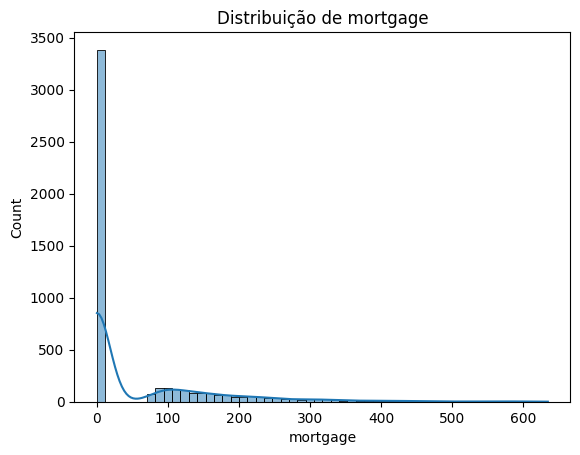

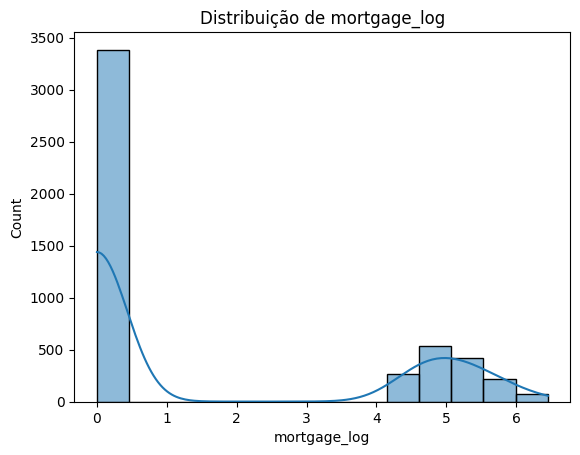

In [118]:
for col in mortgage_df.columns:
    sns.histplot(mortgage_df[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.show()

### Analysis and preprocess for categorical features

In [126]:
df_categorical

,age_bracket_name,personal_loan,education,securities_account,cd_account,online
0,Generation Z,0,1,1,0,0
1,Generation X,0,1,1,0,0
2,Millennials,0,1,0,0,0
3,Millennials,0,2,0,0,0
4,Millennials,0,2,0,0,0
...,...,...,...,...,...,...
4889,Millennials,0,3,0,0,1
4890,Millennials,0,1,0,0,1
4891,Baby boomers,0,3,0,0,0
4892,Baby boomers,0,2,0,0,1


In [124]:
df_categorical['education'].value_counts().to_dict()

{1: 2035, 3: 1475, 2: 1384}

In [137]:
for col in df_categorical.columns:
    print(f'|---|\n Column name:{df_categorical[col].value_counts()}')

|---|
 Column name:age_bracket_name
Generation X    2029
Millennials     1907
Baby boomers     788
Generation Z     170
Name: count, dtype: int64
|---|
 Column name:personal_loan
0    4415
1     479
Name: count, dtype: int64
|---|
 Column name:education
1    2035
3    1475
2    1384
Name: count, dtype: int64
|---|
 Column name:securities_account
0    4383
1     511
Name: count, dtype: int64
|---|
 Column name:cd_account
0    4594
1     300
Name: count, dtype: int64
|---|
 Column name:online
1    2919
0    1975
Name: count, dtype: int64


In [151]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(df[['age_bracket_name', 'education']])

In [152]:
X_encoded.data

array([1., 1., 1., ..., 1., 1., 1.])

In [153]:
df_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(['age_bracket_name', 'education']))

df_categorical.reset_index(drop=True, inplace=True)
df_numerical.reset_index(drop=True, inplace=True)

df_preprocessed = pd.concat([df_categorical, df_numerical, df_encoded], axis=1)

In [154]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894 entries, 0 to 4893
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age_bracket_name               4894 non-null   object 
 1   personal_loan                  4894 non-null   int64  
 2   education                      4894 non-null   int64  
 3   securities_account             4894 non-null   int64  
 4   cd_account                     4894 non-null   int64  
 5   online                         4894 non-null   int64  
 6   mortgage_log                   4894 non-null   float64
 7   age                            4894 non-null   int64  
 8   experience                     4894 non-null   int64  
 9   income                         4894 non-null   int64  
 10  family                         4894 non-null   int64  
 11  mortgage                       4894 non-null   int64  
 12  age_bracket_name_Baby boomers  4894 non-null   f